In [3]:
!pip install yfinance


  Using cached lxml-4.6.3-cp37-cp37m-win_amd64.whl (3.5 MB)
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23909 sha256=1933fea795271fb69aa99ef1ac4a0857572be443d04fc4b363756df4fd88552f
  Stored in directory: c:\users\baps\appdata\local\pip\cache\wheels\fe\87\8b\7ec24486e001d3926537f5f7801f57a74d181be25b11157983
  Created wheel for multitasking: filename=multitasking-0.0.9-py3-none-any.whl size=8368 sha256=d84b6ef1a24862bb430bbec4cd48cef42650a10bd3fff57a3d141a516a63c1cd
  Stored in directory: c:\users\baps\appdata\local\pip\cache\wheels\ae\25\47\4d68431a7ec1b6c4b5233365934b74c1d4e665bf5f968d363a
Successfully built yfinance multitasking


In [17]:
from sklearn.linear_model import LinearRegression

# pandas and numpy are used for data manipulation
import pandas as pd
import numpy as np

# matplotlib and seaborn are used for plotting graphs
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

# yahoo finance is used to fetch data
import yfinance as yf

[*********************100%***********************]  1 of 1 completed


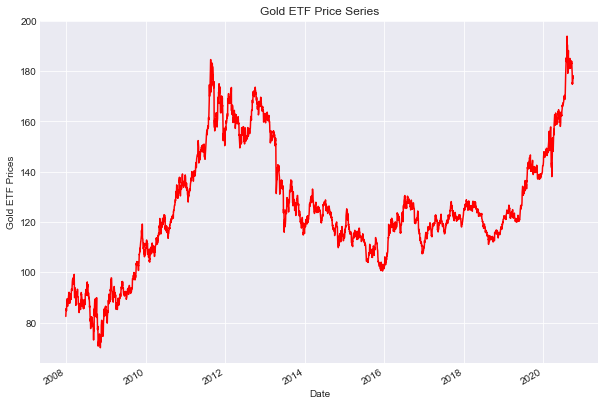

In [18]:
Df = yf.download('GLD', '2008-01-01', '2020-10-01', auto_adjust=True)

# Only keep close columns
Df = Df[['Close']]

# Drop rows with missing values
Df = Df.dropna()

# Plot the closing price of GLD
Df.Close.plot(figsize=(10, 7),color='r')
plt.ylabel("Gold ETF Prices")
plt.title("Gold ETF Price Series")
plt.show()

In [19]:
Df['S_3'] = Df['Close'].rolling(window=3).mean()
Df['S_9'] = Df['Close'].rolling(window=9).mean()
Df['next_day_price'] = Df['Close'].shift(-1)

Df = Df.dropna()
X = Df[['S_3', 'S_9']]

# Define dependent variable
y = Df['next_day_price']

In [20]:
# Split the data into train and test dataset
t = .8
t = int(t*len(Df))

# Train dataset
X_train = X[:t]
y_train = y[:t]

# Test dataset
X_test = X[t:]
y_test = y[t:]


In [21]:
# Create a linear regression model
linear = LinearRegression().fit(X_train, y_train)
print("Linear Regression model")
print("Gold ETF Price (y) = %.2f * 3 Days Moving Average (x1) \
+ %.2f * 9 Days Moving Average (x2) \
+ %.2f (constant)" % (linear.coef_[0], linear.coef_[1], linear.intercept_))

Linear Regression model
Gold ETF Price (y) = 1.20 * 3 Days Moving Average (x1) + -0.21 * 9 Days Moving Average (x2) + 0.44 (constant)


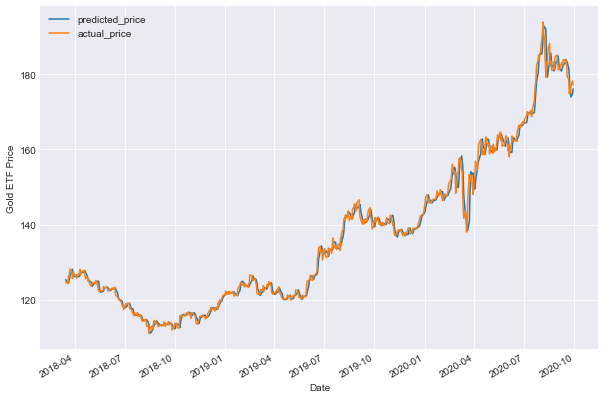

In [22]:
# Predicting the Gold ETF prices
predicted_price = linear.predict(X_test)
predicted_price = pd.DataFrame(
    predicted_price, index=y_test.index, columns=['price'])
predicted_price.plot(figsize=(10, 7))
y_test.plot()
plt.legend(['predicted_price', 'actual_price'])
plt.ylabel("Gold ETF Price")
plt.show()

In [23]:
# R square
r2_score = linear.score(X[t:], y[t:])*100
float("{0:.2f}".format(r2_score))

99.26

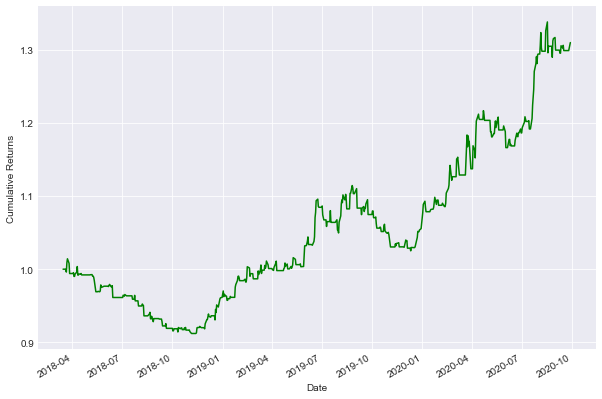

In [24]:
gold = pd.DataFrame()

gold['price'] = Df[t:]['Close']
gold['predicted_price_next_day'] = predicted_price
gold['actual_price_next_day'] = y_test
gold['gold_returns'] = gold['price'].pct_change().shift(-1)

gold['signal'] = np.where(gold.predicted_price_next_day.shift(1) < gold.predicted_price_next_day,1,0)

gold['strategy_returns'] = gold.signal * gold['gold_returns']
((gold['strategy_returns']+1).cumprod()).plot(figsize=(10,7),color='g')
plt.ylabel('Cumulative Returns')
plt.show()

In [25]:
# Calculate sharpe ratio
sharpe = gold['strategy_returns'].mean()/gold['strategy_returns'].std()*(252**0.5)
'Sharpe Ratio %.2f' % (sharpe)

'Sharpe Ratio 1.11'

In [34]:
# import datetime and get today's date
import datetime as dt
current_date = dt.datetime.now()

# Get the data
data = yf.download('GLD', '2008-06-01',current_date, auto_adjust=True)
data['S_3'] = data['Close'].rolling(window=3).mean()
data['S_9'] = data['Close'].rolling(window=9).mean()
data = data.dropna()

# Forecast the price
data['predicted_gold_price'] = linear.predict(data[['S_3', 'S_9']])
data['signal'] = np.where(data.predicted_gold_price.shift(1) < data.predicted_gold_price,"Buy","No Position")

# Print the forecast
data.tail(1)[['signal','predicted_gold_price']].T

[*********************100%***********************]  1 of 1 completed


C:\Users\baps\anaconda3\envs\sparknlp\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\baps\anaconda3\envs\sparknlp\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


Date,2021-10-12
signal,Buy
predicted_gold_price,164.093108
